# The Stanford Sentiment Treebank 
The Stanford Sentiment Treebank consists of sentences from movie reviews and human annotations of their sentiment. The task is to predict the sentiment of a given sentence. We use the two-way (positive/negative) class split, and use only sentence-level labels.

In [1]:
from IPython.display import display, Markdown
with open('../../doc/env_variables_setup.md', 'r') as fh:
    content = fh.read()
display(Markdown(content))

Environment variables that need to be defined:   
`export DIR_PROJ=your_path_git_repository`  
`export PYTHONPATH=$DIR_PROJ/src`  
`export PATH_TENSORBOARD=your_path_tensorboard`  
`export PATH_DATASETS=your_path_datasets`  
`export PROJECT_ID=your_gcp_project_id`  
`export BUCKET_NAME=your_gcp_gs_bucket_name`  
`export REGION=your_region`  
`export PATH_SAVE_MODEL=your_path_to_save_model` 

- Use local Jupyter Lab 
    - you need to have the `jupyter-notebook` Anaconda python environment created [link](local_jupyter_lab_installation.md) 
    - you need to have the `jupyter-notebook` Anaconda python environment activated [link](local_jupyter_lab_installation.md) 
    - then define the environment variables above (copy and paste) 
    - you need to have the `env_multilingual_class` Anaconda python environment created [link](local_jupyter_lab_installation.md)  
    - start Jupyter Lab:  `jupyter lab` 
    - open a Jupyter Lab notebook from `notebook/` 
     - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - choose the proper Anaconda python environment:  `Python [conda env:env_multilingual_class]` [link](conda_env.md) 
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`


- Use GCP Jupyter Lab 
    - Go on GCP
    - open a Cloud Shell
    - `ssh-keygen -t rsa -b 4096 -C firstName_lastName`
    - `cp .ssh/id_rsa.pub .`
    - use Cloud Editor to edit this file `id_rsa.pub` and copy the full content
    - Go on Compute Engine -> Metadata
    - Click SSH Keys
    - Click Edit
    - Click + Add item, copy the content of `id_rsa.pub`
    - You should see firstName_lastName of the left
    - Click Save
    - you need to start a AI Platform instance 
    - open a Jupyter Lab terminal and got to `/home/gcp_user_name/`
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - then `cd proj_multilingual_text_classification/`
    - create the Anacond Python environment `conda env create -f env/environment.yml`
    - create a file `config.sh` in `/home` with the following information: 
    ```
    #!/bin/bash
    
    echo "applying some configuration ..."
    git config --global user.email user_email
    git config --global user.name user_name
    git config --global credential.helper store
        
    # Add here the enviroment variables from above below
    # [EDIT ME]
    export DIR_PROJ=your_path_git_repository
    export PYTHONPATH=$DIR_PROJ/src
  
    cd /home/gcp_user_name/
    
    conda activate env_multilingual_class

    export PS1='\[\e[91m\]\u@:\[\e[32m\]\w\[\e[0m\]$'
    ```
    - Got to AI Platform Notebook, select your instance and click "Reset".
    - Wait and reshreh you Web browser with the Notebook


## Import Packages

In [64]:
import tensorflow as tf
import tensorflow_datasets

from tensorflow.keras.utils import to_categorical

from transformers import (
    BertConfig,
    BertTokenizer,
    XLMRobertaTokenizer,
    TFBertModel,
    TFXLMRobertaModel,
    TFBertForSequenceClassification,
    glue_convert_examples_to_features,
    glue_processors
)

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

from google.cloud import storage

import math
import numpy as np
import os
import glob
import time
from datetime import timedelta
import shutil
from datetime import datetime
import pickle
import re

## Check configuration

In [3]:
print(tf.version.GIT_VERSION, tf.version.VERSION)

v2.1.0-rc2-17-ge5bf8de410 2.1.0


In [4]:
print(tf.keras.__version__)

2.2.4-tf


In [5]:
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)>0:
    for gpu in gpus:
        print('Name:', gpu.name, '  Type:', gpu.device_type)
else:
    print('No GPU available !!!!')

No GPU available !!!!


## Define Paths

In [6]:
try:
    data_dir=os.environ['PATH_DATASETS']
except KeyError:
    print('missing PATH_DATASETS')
try:   
    tensorboard_dir=os.environ['PATH_TENSORBOARD']
except KeyError:
    print('missing PATH_TENSORBOARD')
try:   
    savemodel_dir=os.environ['PATH_SAVE_MODEL']
except KeyError:
    print('missing PATH_SAVE_MODEL')

## Import local packages

In [74]:
import preprocessing.preprocessing as pp
import utils.model_metrics as mm
import utils.model_utils as mu
import model.tf_custom_bert_classification.model as tf_custom_bert
import model.tf_bert_classification.model as tf_bert

In [75]:
import importlib
importlib.reload(pp);
importlib.reload(mm);
importlib.reload(mu);
importlib.reload(tf_bert);
importlib.reload(tf_custom_bert);

## Read data from TFRecord files

In [9]:
# Path of the directory with TFRecord files
tfrecord_data_dir=data_dir+'/tfrecord/sst2'

In [10]:
# TFRecords encode and store data
train_files = tf.data.TFRecordDataset(tfrecord_data_dir+'/train_dataset.tfrecord')
test_files = tf.data.TFRecordDataset(tfrecord_data_dir+'/test_dataset.tfrecord')
valid_files = tf.data.TFRecordDataset(tfrecord_data_dir+'/valid_dataset.tfrecord')

In [11]:
train_dataset = train_files.map(pp.parse_tfrecord_glue_files)
test_dataset = test_files.map(pp.parse_tfrecord_glue_files)
valid_dataset = valid_files.map(pp.parse_tfrecord_glue_files)

In [12]:
# adding the number of entries
if tf.version.VERSION[0:5]=='2.2.0':
    train_dataset=train_dataset2.apply(tf.data.experimental.assert_cardinality(train_dataset2.reduce(0, lambda x, _: x + 1).numpy()))
    test_dataset=test_dataset2.apply(tf.data.experimental.assert_cardinality(test_dataset2.reduce(0, lambda x, _: x + 1).numpy()))
    valid_dataset=valid_dataset2.apply(tf.data.experimental.assert_cardinality(valid_dataset2.reduce(0, lambda x, _: x + 1).numpy()))

## Define parameters of the model

In [13]:
# models
#MODELS = [(TFBertModel,     BertTokenizer,       'bert-base-multilingual-uncased'),
#          (OpenAIGPTModel,  OpenAIGPTTokenizer,  'openai-gpt'),
#          (GPT2Model,       GPT2Tokenizer,       'gpt2'),
#          (CTRLModel,       CTRLTokenizer,       'ctrl'),
#          (TransfoXLModel,  TransfoXLTokenizer,  'transfo-xl-wt103'),
#          (XLNetModel,      XLNetTokenizer,      'xlnet-base-cased'),
#          (XLMModel,        XLMTokenizer,        'xlm-mlm-enfr-1024'),
#          (DistilBertModel, DistilBertTokenizer, 'distilbert-base-cased'),
#          (RobertaModel,    RobertaTokenizer,    'roberta-base'),
#          (XLMRobertaModel, XLMRobertaTokenizer, 'xlm-roberta-base'),
#         ]
MODELS = [(TFBertModel,         BertTokenizer,       'bert-base-multilingual-uncased'),
          (TFXLMRobertaModel,   XLMRobertaTokenizer, 'jplu/tf-xlm-roberta-base')]
model_index = 0 # BERT
model_class        = MODELS[model_index][0] # i.e TFBertModel
tokenizer_class    = MODELS[model_index][1] # i.e BertTokenizer
pretrained_weights = MODELS[model_index][2] #'i.e bert-base-multilingual-uncased'

# Maxium length, becarefull BERT max length is 512!
MAX_LENGTH = 128

# define parameters
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = 32
BATCH_SIZE_VALID = 64
EPOCH = 2

# extract parameters
if tf.version.VERSION[0:5]=='2.2.0':
    size_train_dataset = tf.data.experimental.cardinality(train_dataset)
    size_test_dataset = tf.data.experimental.cardinality(test_dataset)
    size_valid_dataset = tf.data.experimental.cardinality(valid_dataset)
else:
    size_train_dataset = train_dataset.reduce(0, lambda x, _: x + 1).numpy()
    size_test_dataset = test_dataset.reduce(0, lambda x, _: x + 1).numpy()
    size_valid_dataset = valid_dataset.reduce(0, lambda x, _: x + 1).numpy()
number_label = 2                                                        

# computer parameter
STEP_EPOCH_TRAIN = math.ceil(size_train_dataset/BATCH_SIZE_TRAIN)
STEP_EPOCH_TEST = math.ceil(size_test_dataset/BATCH_SIZE_TEST)
STEP_EPOCH_VALID = math.ceil(size_test_dataset/BATCH_SIZE_VALID)


print('Dataset size:          {:6}/{:6}/{:6}'.format(size_train_dataset, size_test_dataset, size_valid_dataset))
print('Batch size:            {:6}/{:6}/{:6}'.format(BATCH_SIZE_TRAIN, BATCH_SIZE_TEST, BATCH_SIZE_VALID))
print('Step per epoch:        {:6}/{:6}/{:6}'.format(STEP_EPOCH_TRAIN, STEP_EPOCH_TEST, STEP_EPOCH_VALID))
print('Total number of batch: {:6}/{:6}/{:6}'.format(STEP_EPOCH_TRAIN*(EPOCH+1), STEP_EPOCH_TEST*(EPOCH+1), STEP_EPOCH_VALID*(EPOCH+1)))

Dataset size:           67349/  1821/   872
Batch size:                32/    32/    64
Step per epoch:          2105/    57/    29
Total number of batch:   6315/   171/    87


In [14]:
pp.print_info_data(train_dataset,print_example=False)

# Structure of the data:

   <MapDataset shapes: ({input_ids: (None,), attention_mask: (None,), token_type_ids: (None,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32, token_type_ids: tf.int32}, tf.int64)>

# Output shape of one entry:
   ({'input_ids': TensorShape([None]), 'attention_mask': TensorShape([None]), 'token_type_ids': TensorShape([None])}, TensorShape([]))

# Output types of one entry:
   ({'input_ids': tf.int32, 'attention_mask': tf.int32, 'token_type_ids': tf.int32}, tf.int64)

# Output typesof one entry:
   ({'input_ids': <class 'tensorflow.python.framework.ops.Tensor'>, 'attention_mask': <class 'tensorflow.python.framework.ops.Tensor'>, 'token_type_ids': <class 'tensorflow.python.framework.ops.Tensor'>}, <class 'tensorflow.python.framework.ops.Tensor'>)
 

# Shape of the data:

   (67349, 2)
   ---> 67349 batches
   ---> 2 dim
        label
           shape: ()
        dict structure
           dim: 3
           [input_ids       / attention_mask  / token_

## Prepare the data: reshuffle and batches

In [15]:
# set shuffle and batch size
train_dataset = train_dataset.shuffle(100).batch(BATCH_SIZE_TRAIN).repeat(EPOCH+1)
test_dataset = test_dataset.shuffle(100).batch(BATCH_SIZE_TEST).repeat(EPOCH+1)
valid_dataset = valid_dataset.batch(BATCH_SIZE_VALID) #.repeat(EPOCH+1)

## Tokenizer and pretrained model


In [16]:
# Define the checkpoint directory to store the checkpoints
pretrained_model_dir=savemodel_dir+'/pretrained_model/'+pretrained_weights
os.makedirs(pretrained_model_dir, exist_ok=True)

## Building a classification model

### Use TFBertForSequenceClassification

In [17]:
# Define some parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
# Gradient clipping in the optimizer (by setting clipnorm or clipvalue) is currently unsupported when using a distribution strategy
# clipnorm=1.0

# loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Uses the tf.distribute.MirroredStrategy, which does in-graph replication with synchronous training on many GPUs on one machine
strategy_model_1 = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy_model_1.num_replicas_in_sync))

# create and compile the Keras model in the context of strategy.scope
with strategy_model_1.scope():
    # metric
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    
    # model
    model_1 = TFBertForSequenceClassification.from_pretrained(pretrained_weights,num_labels=number_label, cache_dir=pretrained_model_dir)
    #model.layers[-1].activation = tf.keras.activations.softmax
    model_1._name='tf_bert_classification'
    model_1.compile(optimizer=optimizer,
                    loss=loss, 
                    metrics=[metric])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


In [18]:
model_1.summary()

Model: "tf_bert_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  167356416 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 167,357,954
Trainable params: 167,357,954
Non-trainable params: 0
_________________________________________________________________


### Building a custom classification model 

In [19]:
def custom_keras_model(number_classes, bert_model, model_class):

    # create model
    input_layer = tf.keras.Input(shape = (128,), dtype='int64')    
    #bert_ini = TFBertModel.from_pretrained(bert_model, cache_dir=pretrained_model_dir) (input_layer)
    bert_ini = model_class.from_pretrained(bert_model, cache_dir=pretrained_model_dir) (input_layer)
    # This is because in a bert pretraining progress, there are two tasks: 
    # masked token prediction and next sentence predition . 
    # The first needs hidden state of each tokens ( shape: [batch_size, sequence_length, hidden_size]) 
    # the second needs the embedding of the whole sequence (shape : [batch_size, hidden_size] ) .
    bert = bert_ini[1]    
    dropout = tf.keras.layers.Dropout(0.1)(bert)
    flat = tf.keras.layers.Flatten()(dropout)
    classifier = tf.keras.layers.Dense(units=number_classes )(flat) # activation='softmax'               
    
    model = tf.keras.Model(inputs=input_layer, outputs=classifier, name='custom_tf_bert_classification')

    return model, bert_ini

In [20]:
# Define some parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
# Gradient clipping in the optimizer (by setting clipnorm or clipvalue) is currently unsupported when using a distribution strategy
# clipnorm=1.0

# loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Uses the tf.distribute.MirroredStrategy, which does in-graph replication with synchronous training on many GPUs on one machine
strategy_model_2 = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy_model_2.num_replicas_in_sync))

# create and compile the Keras model in the context of strategy.scope
with strategy_model_2.scope():
    # metric
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    
    # model
    model_2, bert_ini = custom_keras_model(number_label, pretrained_weights, model_class)
    model_2.compile(optimizer=optimizer,
                    loss=loss, 
                    metrics=[metric])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


In [21]:
bert_ini[0]

<tf.Tensor 'tf_bert_model/Identity:0' shape=(None, 128, 768) dtype=float32>

In [22]:
bert_ini[1]

<tf.Tensor 'tf_bert_model/Identity_1:0' shape=(None, 768) dtype=float32>

In [23]:
model_2.summary()

Model: "custom_tf_bert_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 128, 768), (None, 167356416 
_________________________________________________________________
dropout_75 (Dropout)         (None, 768)               0         
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1538      
Total params: 167,357,954
Trainable params: 167,357,954
Non-trainable params: 0
_________________________________________________________________


## Select the model for training

In [24]:
model=model_1
print('model\'s name: {}'.format(model.name))

model's name: tf_bert_classification


In [76]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# create and compile the Keras model in the context of strategy.scope
with strategy.scope():
    model=tf_bert.create_model(pretrained_weights, 
                               pretrained_model_dir=pretrained_model_dir, 
                               num_labels=number_label, 
                               learning_rate=3e-5, 
                               epsilon=1e-08)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


In [79]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# create and compile the Keras model in the context of strategy.scope
with strategy.scope():
    model=tf_custom_bert.create_model(pretrained_weights, 
                                      model_class, 
                                      MAX_LENGTH, 
                                      pretrained_model_dir=pretrained_model_dir, 
                                      num_labels=number_label, 
                                      learning_rate=3e-5, 
                                      epsilon=1e-08,
                                      print_info=False)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


In [77]:
model.summary()

Model: "tf_bert_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  167356416 
_________________________________________________________________
dropout_113 (Dropout)        multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 167,357,954
Trainable params: 167,357,954
Non-trainable params: 0
_________________________________________________________________


## Setup of the Callbacks

### TensorBoard

In [25]:
# checking existing folders
for i in os.listdir(tensorboard_dir):
    if os.path.isdir(tensorboard_dir+'/'+i):
        print(i)

20200413-165920


In [26]:
# clean old TensorBoard directory 
for i in os.listdir(tensorboard_dir):
        if os.path.isdir(tensorboard_dir+'/'+i):
            print('remiving:', i)
            shutil.rmtree(tensorboard_dir+'/'+i, ignore_errors=False)

remiving: 20200413-165920


In [27]:
# create a new directory
log_dir=tensorboard_dir+'/'+datetime.now().strftime("%Y%m%d-%H%M%S")
os.mkdir(log_dir)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1, 
                                                      embeddings_freq=1,
                                                      write_graph=True,
                                                      update_freq='batch',
                                                      profile_batch=1)

### Model Checkpoints

In [28]:
# Define the checkpoint directory to store the checkpoints
checkpoint_dir=savemodel_dir+'/checkpoint_model/'+model.name
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch:02d}') 
#checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch:02d}-{accuracy:.4f}')

In [29]:
# clean old checkpoints
for i in os.listdir(checkpoint_dir):
        if os.path.exists(checkpoint_dir+'/'+i):
            os.remove(checkpoint_dir+'/'+i)

In [30]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                         verbose=1,
                                                         save_weights_only=True)

#checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
#                                                         monitor='accuracy',
#                                                         save_best_only=True,
#                                                         mode='max',
#                                                         save_freq=2,
#                                                         period=5,
#                                                         verbose=1,
#                                                         save_weights_only=True)

### Decaying learning rate

In [31]:
decay_callback = tf.keras.callbacks.LearningRateScheduler(mu.decay)

### Checks callbacks

In [32]:
list_callback = [tensorboard_callback, checkpoint_callback, decay_callback]
for cb in list_callback:
    if type(cb).__name__=='tuple':
        print(cb[0].__class__.__name__, 'need to unpack this tuple by adding *')

Maybe some callback need to unpack this tuple by adding *

## TensorBoard

In [33]:
%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard  --logdir   {log_dir} \
              #--port 6667 \
              #--debugger_port 6667

## Training

In [34]:
# input format depending of the type of model
def data_feature_extraction(data, name):
    if name=='custom_tf_bert_classification':
        print('custom model: {}'.format(name))
        return data.map(pp.feature_selection)
    elif name=='tf_bert_classification':
        print('standard model: {}'.format(name))
        return data
    else:
        print('!!! non defined model !!!!')
        return data

In [35]:
# Clean up existing  weigts and values
tf.keras.backend.clear_session()

In [36]:
# time the function
start_time = time.time()

# making the transformation here since insude model.fit it create a lot of warnings
data_train = data_feature_extraction(train_dataset, model.name)
data_val = data_feature_extraction(valid_dataset, model.name)

# callback to creaate  history per step (not per epoch)
histories_per_step = mu.History_per_step(data_val, 10)


# train the model
history = model.fit(data_train, 
                    epochs=2, 
                    steps_per_epoch=5, #STEP_EPOCH_TRAIN,
                    validation_data=data_val,
                    validation_steps=3,
                    callbacks=[tensorboard_callback,
                               checkpoint_callback,
                               histories_per_step])

# print execution time
elapsed_time_secs = time.time() - start_time
print('\nexecution time: {}'.format(timedelta(seconds=round(elapsed_time_secs))))

standard model: tf_bert_classification
standard model: tf_bert_classification
Train for 5 steps, validate for 3 steps
Epoch 1/2

 training set -> batch:1 loss:0.6904932260513306 and acc: 0.46875
1/5 [=====>........................] - ETA: 2:40 - loss: 0.6905 - accuracy: 0.4688
 training set -> batch:2 loss:0.6941128969192505 and acc: 0.5625
2/5 [===========>..................] - ETA: 1:33 - loss: 0.6923 - accuracy: 0.5625
 training set -> batch:3 loss:0.68711918592453 and acc: 0.5416666865348816
3/5 [=================>............] - ETA: 54s - loss: 0.6906 - accuracy: 0.5417 
 training set -> batch:4 loss:0.6336581707000732 and acc: 0.6171875
4/5 [=======================>......] - ETA: 25s - loss: 0.6763 - accuracy: 0.6172
 training set -> batch:5 loss:0.6793931126594543 and acc: 0.612500011920929

Epoch 00001: saving model to /Users/tarrade/tensorflow_model/checkpoint_model/tf_bert_classification/ckpt_01
5/5 [==============================] - 186s 37s/step - loss: 0.6770 - accuracy: 

## Save the model and histories

### Save the model

In [37]:
savemodel_path = os.path.join(savemodel_dir, 'saved_model')
os.makedirs(savemodel_path, exist_ok=True)

In [38]:
model.save(os.path.join(savemodel_path,model.name))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /Users/tarrade/tensorflow_model/saved_model/tf_bert_classification/assets


In [39]:
# check the saved model
print('Model: {}'.format(model.name))
for i in os.listdir(os.path.join(savemodel_path,model.name)):
        print(' ',i)
            

Model: tf_bert_classification
  variables
  history
  history_per_step
  saved_model.pb
  assets


The **variables** directory contains a standard training checkpoint (see the guide to training checkpoints).   

The **assets** directory contains files used by the TensorFlow graph, for example text files used to initialize vocabulary tables.  

The **saved_model.pb** file stores the actual TensorFlow program, or model, and a set of named signatures, each identifying a function that accepts tensor inputs and produces tensor outputs. SavedModels may contain multiple variants of the model (multiple v1.MetaGraphDefs, identified with the --tag_set flag to saved_model_cli), but this is rare. APIs which create multiple variants of a model include.

### Save the histories

In [40]:
with open(savemodel_path+'/'+model.name+'/history', 'wb') as file:
    model_history= mu.History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

In [41]:
with open(savemodel_path+'/'+model.name+'/history_per_step', 'wb') as file:
    model_history_per_step= mu.History_per_steps_trained_model(histories_per_step.steps, 
                                                               histories_per_step.losses, 
                                                               histories_per_step.accuracies, 
                                                               histories_per_step.val_steps, 
                                                               histories_per_step.val_losses, 
                                                               histories_per_step.val_accuracies)
    pickle.dump(model_history_per_step, file, pickle.HIGHEST_PROTOCOL)

## Metrics during training

### Visualization using Keras callback history

In [42]:
plt.rcParams['figure.figsize'] = [15, 10]

Loss:
  - loss [training dataset]: 0.786
  - loss [validation dataset: 0.701

Accuracy:
  - accuracy [training dataset]: 56.88%
  - accuracy [validation dataset: 50.92%


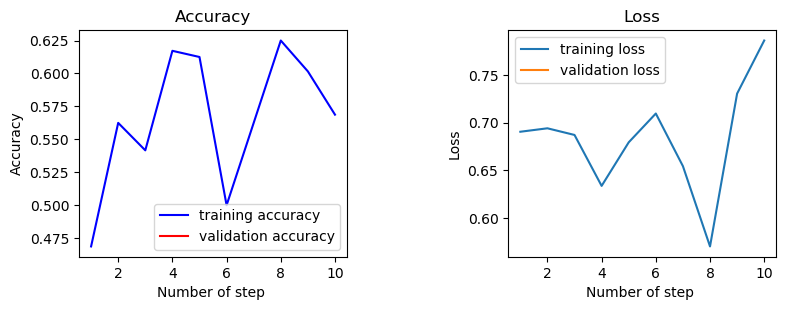

In [43]:
mm.plot_acc_loss(steps_loss_train=histories_per_step.steps, loss_train=histories_per_step.losses,
                 steps_acc_train=histories_per_step.steps, accuracy_train=histories_per_step.accuracies,
                 steps_loss_eval=histories_per_step.val_steps, loss_eval=histories_per_step.val_losses,
                 steps_acc_eval=histories_per_step.val_steps, accuracy_eval=histories_per_step.val_accuracies)

### Visualization using TenorBoard callback

In [44]:
history_train=mu.load_data_tensorboard(log_dir+'/train')
history_val=mu.load_data_tensorboard(log_dir+'/validation')
debug=False


if debug:
    print('\n')
    for file in glob.glob(log_dir+'/train/*'):
        print(re.findall(r'[^\\/]+|[\\/]',file)[-1])
    print('\n')
    print(history_train.keys())
    print('\nnumber of entry for train:', len(history_train['batch_loss'][0]))
    print('\n',history_train)
    print('\nnumber of entry for eval:', len(history_train['epoch_loss'][0]))
    print('\n',history_val)
    print('\n\n\n')

Loss:
  - loss [training dataset]: 0.786
  - loss [validation dataset: 0.694

Accuracy:
  - accuracy [training dataset]: 56.88%
  - accuracy [validation dataset: 52.60%


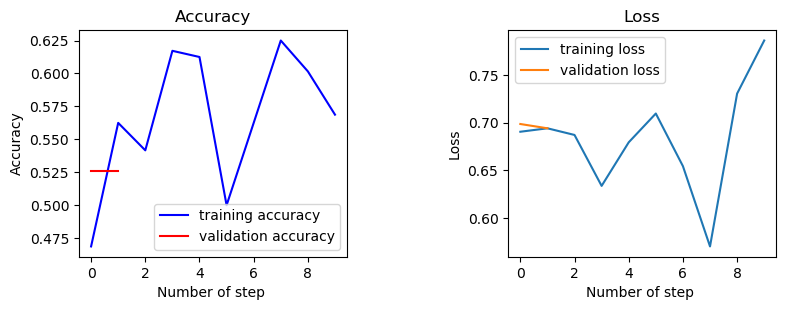

In [45]:
mm.plot_acc_loss(steps_loss_train=history_train['batch_loss'][0], loss_train=history_train['batch_loss'][1],
                 steps_acc_train=history_train['batch_accuracy'][0], accuracy_train=history_train['batch_accuracy'][1],
                 steps_loss_eval=history_val['epoch_loss'][0], loss_eval=history_val['epoch_loss'][1],
                 steps_acc_eval=history_val['epoch_accuracy'][0], accuracy_eval=history_val['epoch_accuracy'][1])

### Metadata

In [46]:
print(model.metrics)
print(model.metrics_names)

['loss', 'accuracy']


In [47]:
history.epoch

[0, 1]

In [48]:
history.params

{'batch_size': None,
 'epochs': 2,
 'steps': 5,
 'samples': 5,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [49]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [50]:
# dir(history)

### Exploration of the model's structure

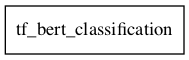

In [51]:
tf.keras.utils.plot_model(model,
                          'model.png',
                          show_shapes=True)

In [52]:
model.inputs

{'attention_mask': <tf.Tensor 'attention_mask:0' shape=(None, 128) dtype=int32>,
 'input_ids': <tf.Tensor 'input_ids:0' shape=(None, 128) dtype=int32>,
 'token_type_ids': <tf.Tensor 'token_type_ids:0' shape=(None, 128) dtype=int32>}

In [53]:
model.outputs

[<tf.Tensor 'tf_bert_classification/Identity:0' shape=(None, 2) dtype=float32>]

In [54]:
model.layers

In [55]:
# _inbound_nodes and inbound_nodes give the same !
# to see method available: dir(model.layers[2])
for layer in model.layers:
    print(layer.name, layer._inbound_nodes, layer._outbound_nodes)

bert [] []
dropout_37 [] []
classifier [] []


## Model's evaluation and validation

### Making prediction

In [56]:
# get probablility for each classes
if model.name=='custom_tf_bert_classification':
        print('custom model: {}'.format(model.name))
        y_pred = tf.nn.softmax(model.predict(valid_dataset))
elif model.name=='tf_bert_classification':
        print('standard model: {}'.format(model.name))
        y_pred = tf.squeeze(tf.nn.softmax(model.predict(valid_dataset)))

standard model: tf_bert_classification


In [57]:
y_pred.shape

TensorShape([872, 2])

In [58]:
# get predicted classes
y_pred_argmax = tf.math.argmax(y_pred, axis=1)        

In [59]:
(y_pred_argmax).shape

TensorShape([872])

### Extracting true classes

In [60]:
# extracting and flatten true classes
y_true_tf=valid_dataset.map(pp.label_extraction).flat_map(lambda x: valid_dataset.from_tensor_slices(x))

In [61]:
y_true=list(y_true_tf.as_numpy_iterator())

In [62]:
len(y_true), len(y_pred_argmax)

(872, 872)

### Model performanes

In [63]:
print(classification_report(y_true, y_pred_argmax, target_names=info.features["label"].names))

NameError: name 'info' is not defined

In [ ]:
mm.print_metrics(y_true, y_pred_argmax, mode='')

### Confusion matrix

In [ ]:
plt.rcParams['figure.figsize'] = [10, 7]

In [ ]:
mm.plot_confusion_matrix(confusion_matrix(y_true, y_pred_argmax), info.features["label"].names)

In [ ]:
mm.plot_confusion_matrix(confusion_matrix(y_true, y_pred_argmax), info.features["label"].names, normalize=True)

### ROC curves

In [ ]:
mm.roc_curves(to_categorical(y_true), y_pred.numpy(), info.features["label"].names)